In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

자동차 보험사의 보험금 청구 예측이 부정확하면 선량한 운전자들의 보험료가 오르고 불량 운전자들의 보험료가 줄어든다.
전자가 다음 해에 자동차 보험 청구를 시작할 확률을 예측하는 모델을 구축
더 정확한 예측은 그들이 가격을 더 맞출 수 있게 해줄 것이고 희망컨대 자동차 보험 혜택을 더 많은 운전자들이 이용할 수 있게 해줄 것이다.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

In [6]:
train = pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('../input/porto-seguro-safe-driver-prediction/test.csv')

**처음 만나는 데이터**

competition에 있는 데이터 요약 중 발췌한 것
- 비슷한 그룹에 속한 특성들은 특성 이름에서처럼 태그되어 있다. (예 : ind, reg, car, calc)
- bin이 붙어 있는 특성은 이진 특성을 나타내기 위해, cat가 붙어있는 특성은 카테고리 특성을 나타내기 위해 이름에 들어 있다.
- 이런게 없는 특성들은 연속적이거나 순서적
- -1 값은 관측값에서 해당 특성이 결측값이라는 뜻
- 타겟 열은 청구가 접수되었는지 여부를 나타낸다

In [8]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [10]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


아래의 것을 알 수 있다
- 이진 변수
- 카테고리값이 숫자인 카테고리 변수
- -1이 있는 변수는 결측값 나타냄
- 타겟 변수와 ID 변수

In [11]:
train.shape

(595212, 59)

59개의 변수와 595,212개의 열을 갖고 있다. 테스트 데이터에도 같은 수의 변수가 있는지 보자.
트레인 데이터에 중복 행이 있는지 보자

In [13]:
train.drop_duplicates()
train.shape

(595212, 59)

중복행 없다

In [14]:
test.shape

(892816, 58)

In [ ]:
테스트 셋에 변수 하나가 없지만 이건 타겟 변수이기 때문에 괜찮다.
각각 타입에 얼마나 많은 변수가 있는지 봐보자.

나중에 우리는 14 카테고리 변수로 더미 변수를 만들 수 있다.
이중 변수는 더미로 만들 필요가 없다

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [ ]:
다시, info()써서 데이터 타입이 정수인지 실수인지 보았다. null값은 없다.
결측값은 -1로 대체되었기 때문에 정상적인 것. 나중에 다시 보자

**메타데이터**
데이터 관리는 용이하게 하기 위해, 데이터프레임 안에 있는 변수에 대한 메타정보를 저장할거다. 이 작업은 분석이나 시각화나 모델링을 할 때 특정 변수를 고를 때 유용할거다.

#이 과정이 왜 필요한지 아직은 잘 모르겠다

구체적으로 다음을 저장할거다
- 역할 : input, ID, target
- 수준 : nominal, interval, ordinal, binary
- keep? : True or False
- 데이터 타입 : int, float, str

In [7]:
data = []
for f in train.columns :
    # 역할 정의
    if f == 'target' :
        role = 'target'
    elif f == 'id' :
        role = 'id'
    else :
        role = 'input'
        
    # 수준 정의
    if 'bin' in f or f == 'target' :
        level = 'binary'
    elif 'cat' in f or f == 'id' :
        level = 'nominal'
    elif train[f].dtype == float :
        level = 'interval'
    elif train[f].dtype == int :
        level = 'ordival'
        
    # id 제외하고 모든 변수 keep을 True로 초기화
    keep = True
    if f == 'id' :
        keep = False
        
    # 데이터 타입 정의
    dtype = train[f].dtype
    
    # 변수의 모든 메타데이터 포함하도록 딕셔너리 생성
    f_dict = {
        'varname' : f,
        'role' : role,
        'level' : level,
        'keep' : keep,
        'dtype' : dtype
    }
    data.append(f_dict)
    
    meta = pd.DataFrame(data, columns = ['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace = True)

In [8]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordival,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordival,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


드롭되지 않은 모든 명목형 변수 추출하는 예

In [10]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

역할과 레벨에 따른 변수의 개수를 보여줌

In [11]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordival,16
5,target,binary,1


**기술통계**

데이터프레임에 describe를 사용할 수 있지만 카테고리 변수나 id 변수에에 평균, 표준편차 등을 구하는건 맞지 않다. 나중에 카테고리 변수에 대해 시각적으로 볼거다

기술 통계 계산을 위해 우리가 원하는 변수를 쉽게 고를 수 있게 해주는 메타 파일에 고맙다.

#아하 카테고리 변수나 id 변수 빼고 원하는 데이터에만 기술 통계량 볼 수 있게

명확하게 하기 위해 데이터 타입에 따라 할 것이다

**등간 변수**

In [18]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


reg 변수
 - ps_reg_03만 결측치가 있다 #-1!!
 - 범위(최소~최대)가 변수마다 다르다. 스케일링(standardscaler 같은) 할 수 있지만 우리가 사용하고 싶은 분류기에 따라 달라진다
 
 #범위가 다르다는건 각 변수마다 min과 max값이 달라서 범위가 너무 크게 차이나서 그런가 이게 무슨 의미지

car 변수
 - ps_car_12 와 ps_car_15 가 결측치가 있다.
 - 다시, 범위가 다르고 스케일링을 적용할 수 있다

calc 변수
 - 결측치가 없다
 - 0.9가 최대라서 어떤 비율처럼 보인다
 - 세 _clac변수 모두 비슷한 분포를 보인다

전반적으로, 우리는 등간 변수의 범위가 다소 작은 것을 볼 수 있었다. 아마 데이터를 익명화하기 위해 어떤 변환(로그 같은)이 이미 적용되어 있지 않을까?

**서열 변수**

In [20]:
v = meta[(meta.level == 'ordival') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- ps_car_11 변수에만 결측치가 있다
- 서로 다른 범위를 다루기 위해 스케일링 적용할 수 있다.

**이진 변수**

In [21]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- 트레인 데이터 안의 priori는 3.645%. 아주 밸런스가 안맞다

#타겟 대부분이 0이라는 말인듯

- 평균에서 우리는 대부분의 변수가 대부분의 경우 0 값을 가진다는 것을 알 수 있다

**균형 안맞는 클래스 처리하기**

위에서 얘기했듯, target=1 인 비율이 0인 경우에 비해 훨씬 적다. 이것은 모델의 정확도를 높일 수 있지만 실제 상황에서 안좋을 수 있다. 이 문제를 해결하기 위해 두 가지 전략이 있다.

- target=1인 기록을 오버샘플링한다
- target=0인 기록을 언더샘플링한다

여러 전략이 있을 수 있지만 우리는 비교적 큰 트레인 셋을 가졌으므로 언더샘플링으로 가겠다

In [23]:
desired_apriori = 0.10

# 타겟 값 당 지수를 얻는다
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# 타겟 값 당 기록의 원래 수 얻는다
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# 언더샘플링률을 계산하고 target=0 기록의 수를 결과낸다
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0 : {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling : {}'.format(undersampled_nb_0))

# 원하는 값을 얻기 위해 target=0 기록을 랜덤하게 선택한다
undersampled_idx = shuffle(idx_0, random_state=37, n_samples = undersampled_nb_0)

# 남은 지표로 리스트 구조화
idx_list = list(undersampled_idx) + list(idx_1)

# 데이터 프레임 언더샘플 한 것을 리턴
train = train.loc[idx_list].reset_index(drop = True)

Rate to undersample records with target=0 : 0.34043569687437886
Number of records with target=0 after undersampling : 195246


#샘플 수 : 595212 -> 195246
#타겟0 비율 : 0.036 -> 0.34

**데이터 질 체크**

**결측값 체크**

결측값은 -1로 표시된다

In [34]:
vars_with_missing = []

for f in train.columns :
    missings = train[train[f] == -1][f].count()
    if missings > 0 :
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
In total, there are 7 variables with missing values


- ps_car_03_cat과 ps_car_05_cat은 결측값 비율이 높다. 이 변수들은 제거하자

#바아로 제거해버리네? 좀 심하긴 하네 68%, 44%면

- 다른 결측값이 있는 카테고리 변수들은 결측값을 그대로 -1로 남겨둬도 되겠다
- ps_reg_03(연속형)은 18%의 결측 비율을 가진다. 평균으로 대체한다
- ps_car_11(순서형)은 5개만 결측치다. 최빈값으로 대체한다
- ps_car_12(연속형)은 1개만 결측치다. 평균으로 대체한다
- ps_car_14(연속형)은 7%의 결측 비율을 가진다. 평균으로 대체한다.

#결측값 대체 방법 다르다. 연속형은 평균으로, 순서형은 최빈값으로

In [33]:
# 너무 많은 결측값을 가지는 변수들 drop
# vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
# train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep'] = False  # 메타데이터 업데이트

# 평균이나 최빈값으로 대치
mean_imp = SimpleImputer(missing_values = -1, strategy = 'mean')
mode_imp = SimpleImputer(missing_values = -1, strategy = 'most_frequent')

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

**카테고리 변수의 카디너리티(중요성?) 체크**

카디너리티란 변수에서 다른 값을 가지는 수를 나타내는 것. 나중에 카테고리 변수에서 더미 변수를 만들거기 때문에, 다른 변수가 많은지 봐야한다. 많은 더미 변수들을 만들어낼 것이므로 이 변수들을 다르게 다뤄야 한다.

#무슨말이지 왜 필요하지 처리는 왜하지

In [36]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v :
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


ps_car_11_cat 변수만 많은 다른 값을 가진다. 이것도 합당하다(괜찮다)

라고 했는데 피드백 받고 다른 커널 참고해서 이거 처리하는 코드 붙이심. 하지만 뭔지 잘 모르겠다..

In [37]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [38]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

**데이터 시각화**

**카테고리 변수**

카테고리 변수와 target=1인 고객 비율을 보자

<Figure size 432x288 with 0 Axes>

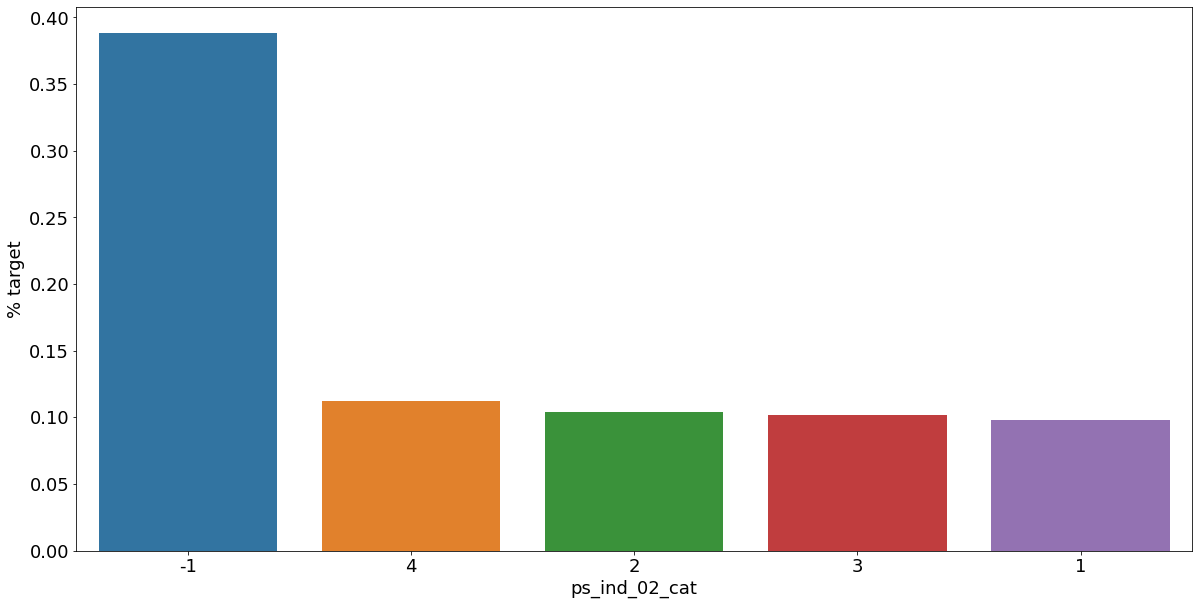

<Figure size 432x288 with 0 Axes>

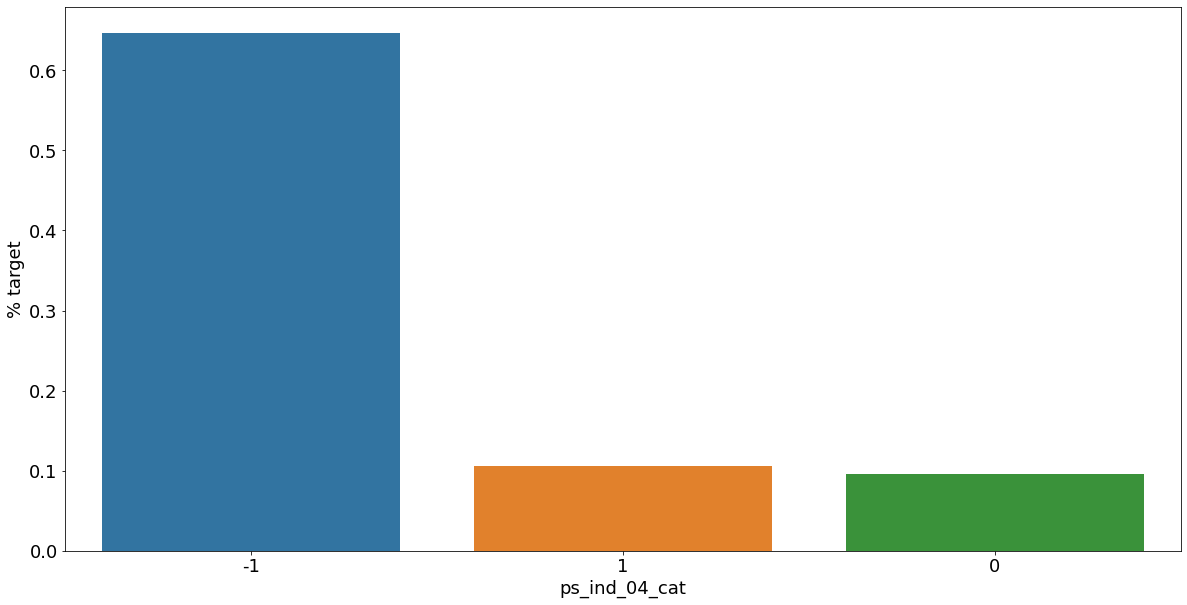

<Figure size 432x288 with 0 Axes>

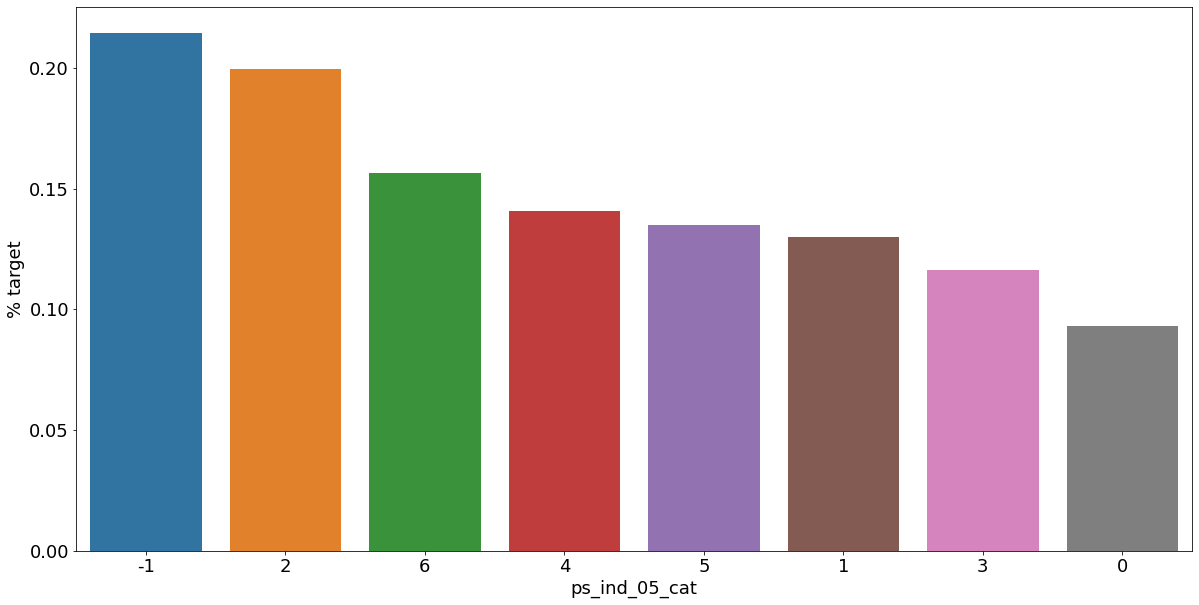

<Figure size 432x288 with 0 Axes>

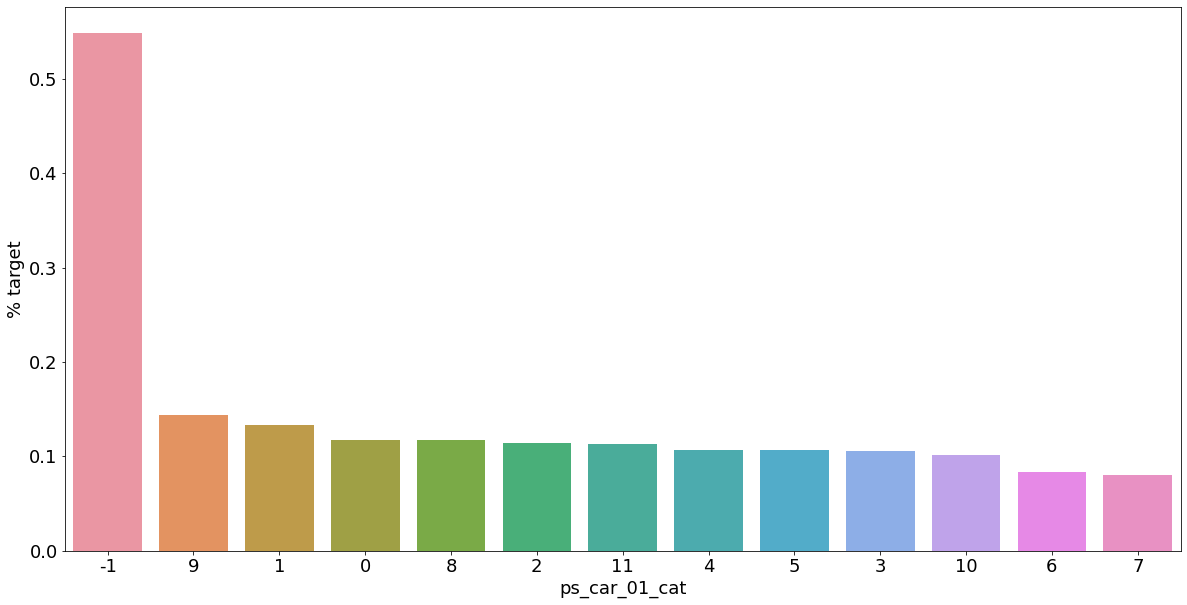

<Figure size 432x288 with 0 Axes>

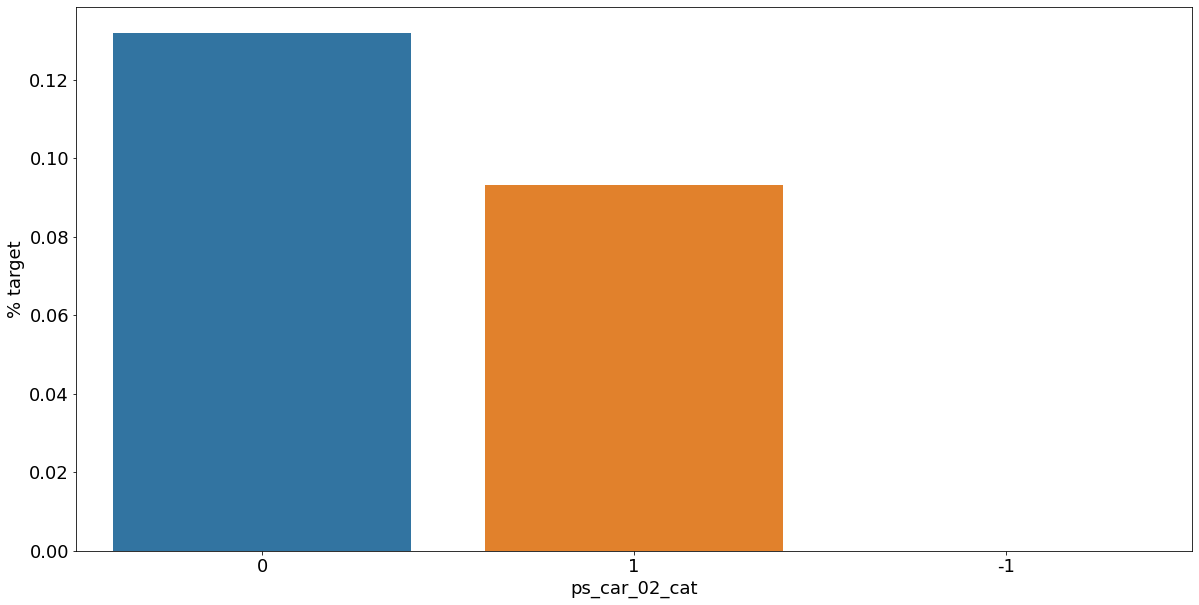

<Figure size 432x288 with 0 Axes>

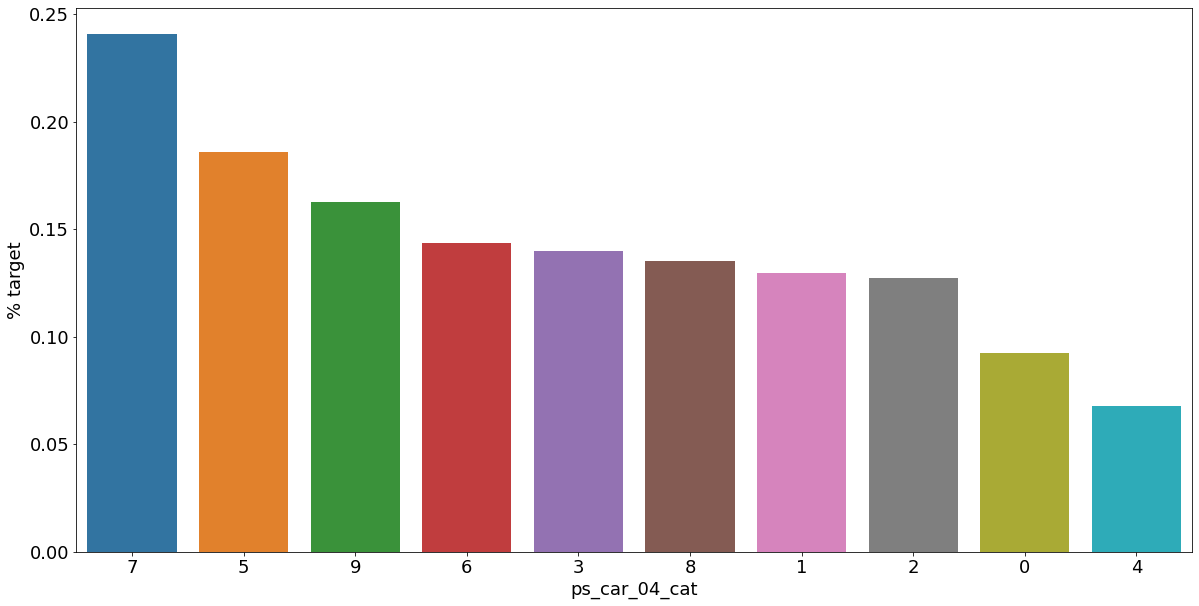

<Figure size 432x288 with 0 Axes>

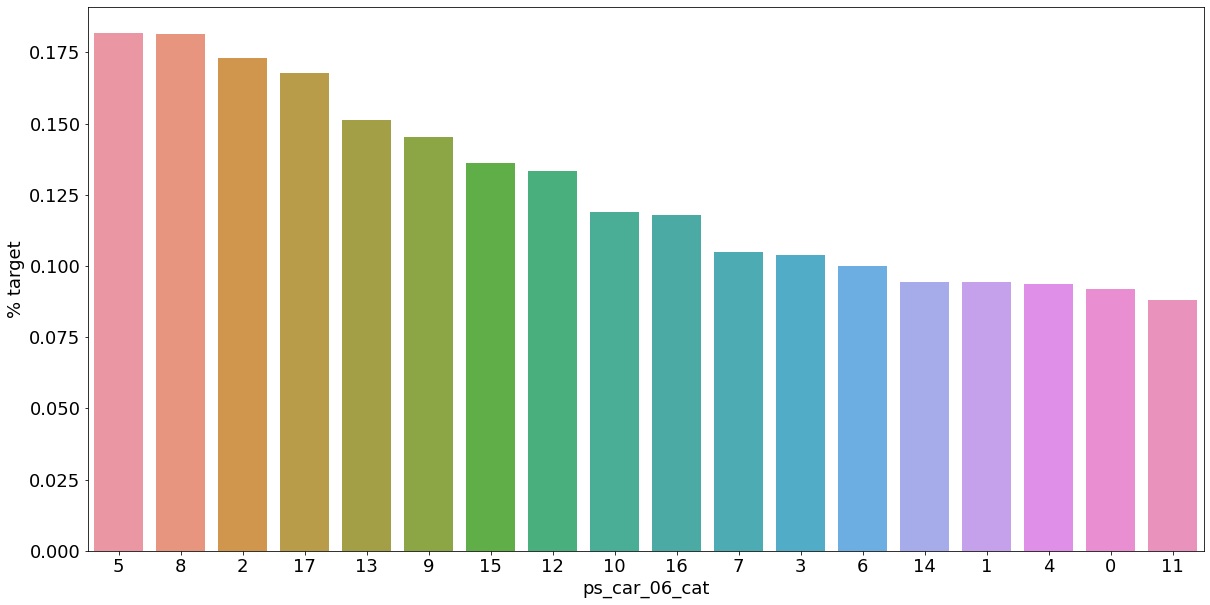

<Figure size 432x288 with 0 Axes>

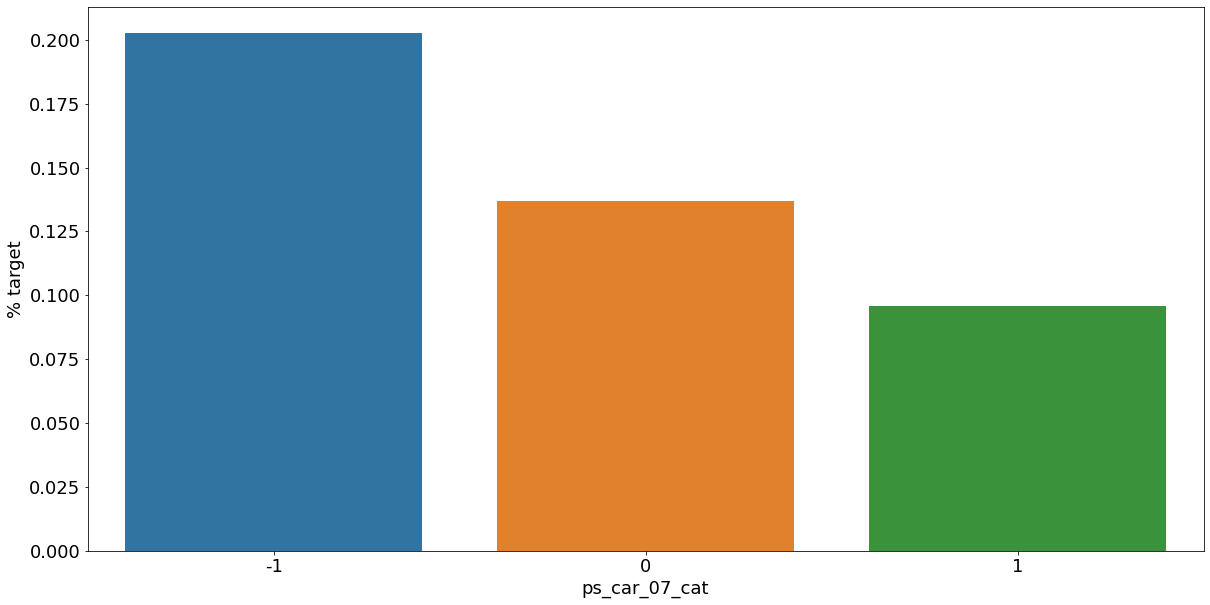

<Figure size 432x288 with 0 Axes>

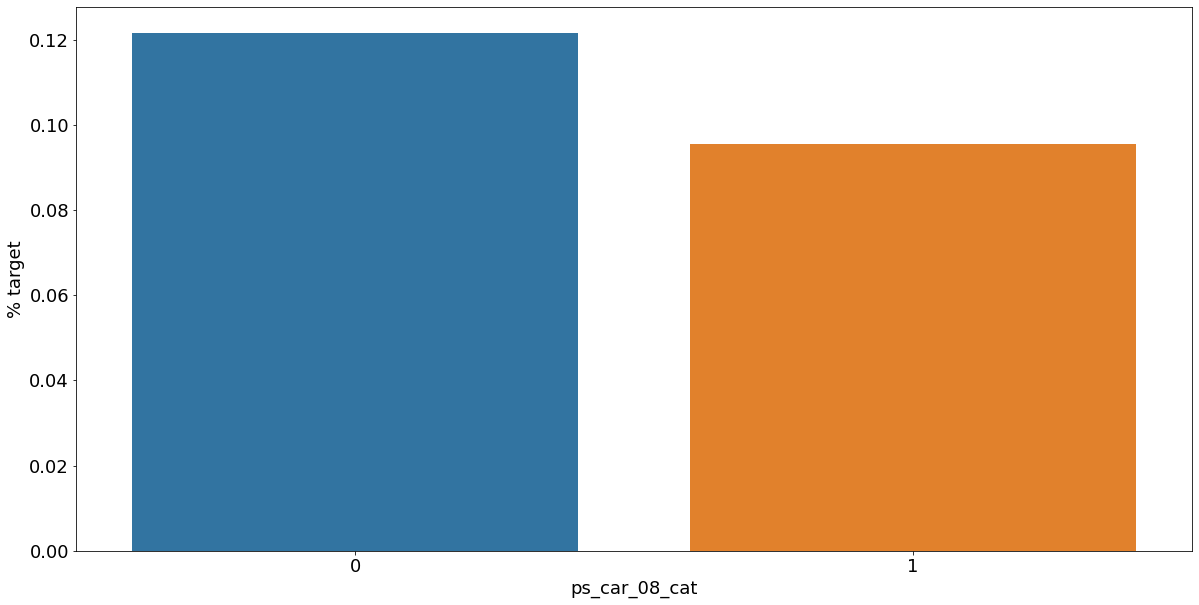

<Figure size 432x288 with 0 Axes>

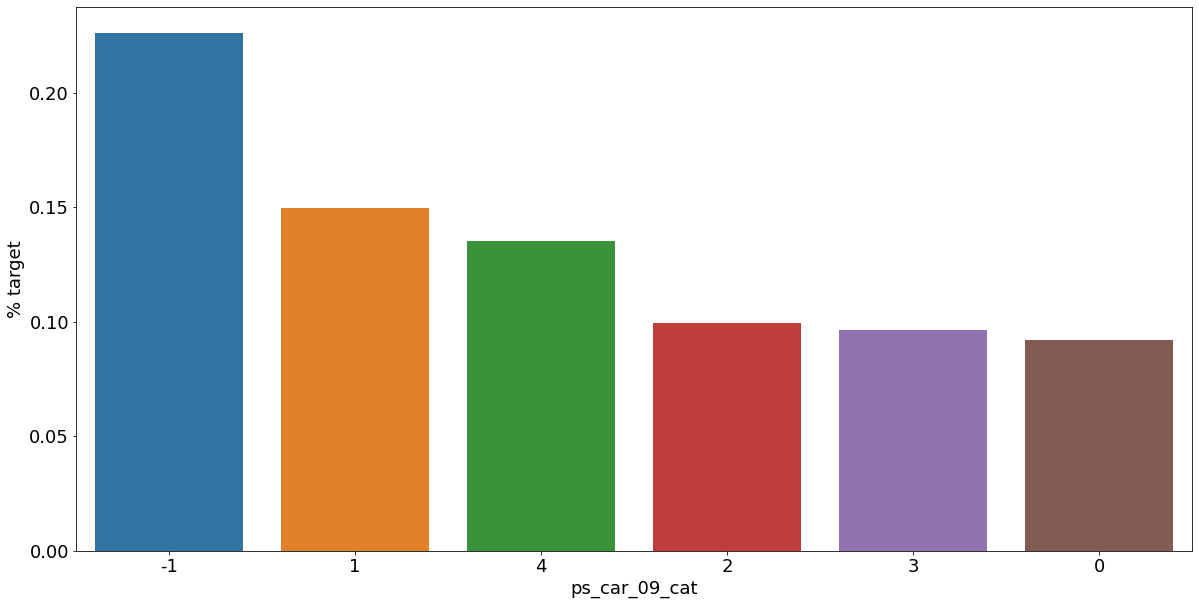

<Figure size 432x288 with 0 Axes>

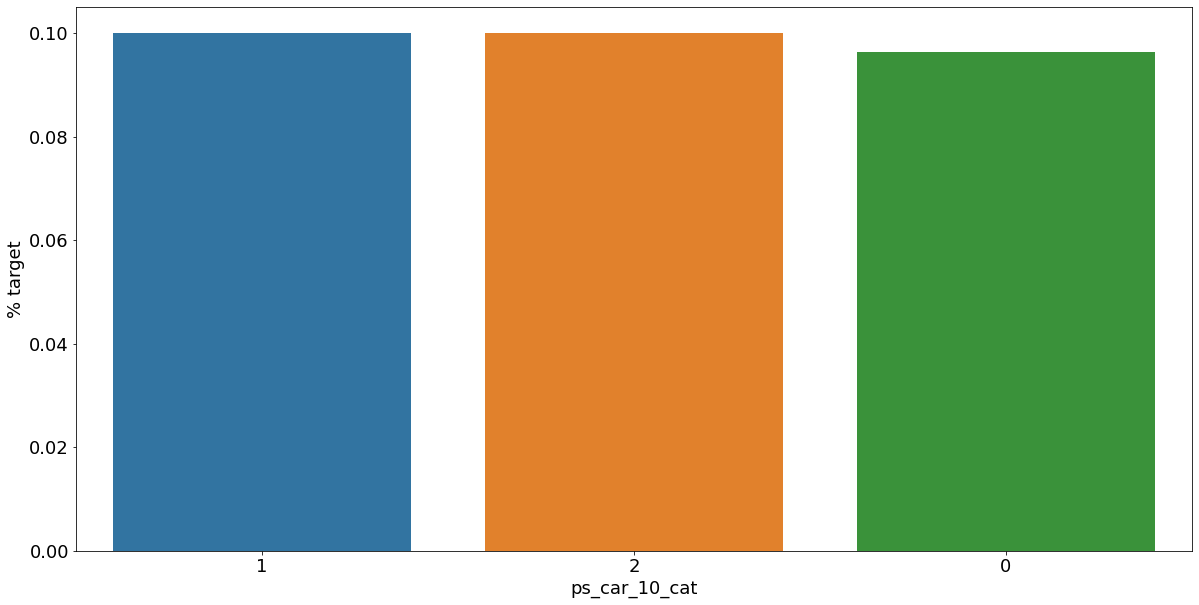

In [39]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v :
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, 10))
    # 카테고리 값 당 target=1 비율 계산
    cat_perc = train[[f, 'target']].groupby([f], as_index = False).mean()
    cat_perc.sort_values(by = 'target', ascending = False, inplace = True)
    # 바 그래프
    # 타겟 평균에 따라 하강하게 바
    sns.barplot(ax=ax, x=f, y='target', data = cat_perc, order = cat_perc[f])
    plt.ylabel('% target', fontsize = 18)
    plt.xlabel(f, fontsize = 18)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
    plt.show()

결측값이 있는 변수에서 보듯, 독립된 카테고리 값으로 결측값을 두는 것은 최빈값 같은 것으로 대체하는 것보다 좋은 것 같다. #왜지

결측값이 있는 고객은 훨씬 많은(어떤 케이스에선 훨씬 낮은 비율) 비율로 보험 청구를 요청한다.

#결측값을 가지면 가장 많이 혹은 가장 적게 보험 청구하네

**등간 변수**

등간 변수 사이의 상관관계를 확인해보자. 히트맵이 변수 사이의 상관관계를 시각화하기에 좋다. 

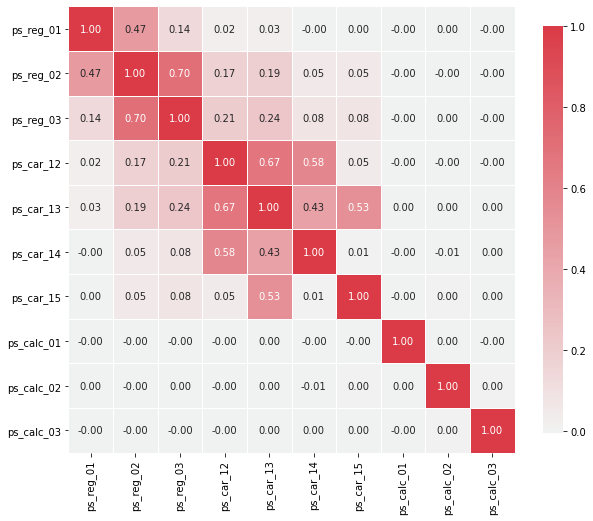

In [40]:
def corr_heatmap(v) :
    correlations = train[v].corr()
    
    # 두 색 사이의 범위로 컬러맵 생성
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', 
               square=True, linewidths=.5, annot=True, cbar_kws={'shrink': .75})
    plt.show()
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

다음의 변수 사이에 강한 상관관계가 있다.
 - ps_reg_02 and ps_reg_03 (0.7)
 - ps_car_12 and ps_car13 (0.67)
 - ps_car_12 and ps_car14 (0.58)
 - ps_car_13 and ps_car15 (0.67)
 
seaborn은 변수 사이의 (선형) 관계를 시각화하기 위한 플롯이 있다. 우리는 pairplot을 사용할 수 있다. 하지만 히트맵이 이미 상관관계가 있는 변수의 한계수를 보여주었으므로 강한 상관관계가 있는 변수들을 따로 보겠다.

과정을 빠르게 진행하기 위해 트레인 데이터에서 샘플링을 했다

In [41]:
s = train.sample(frac = 0.1)

ps_reg_02와 ps_red_03

회귀 선이 보여주듯, 두 변수 사이에 선형 상관관계가 있다. hue 파라미터로 target=0과 target=1 사이의 회귀선을 같게 볼 수 있다.

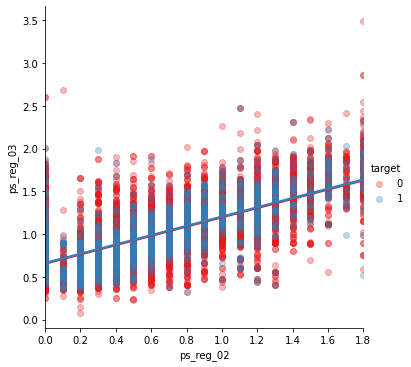

In [43]:
sns.lmplot(x = 'ps_reg_02', y = 'ps_reg_03', data = s, hue = 'target', palette = 'Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_12와 ps_car_13

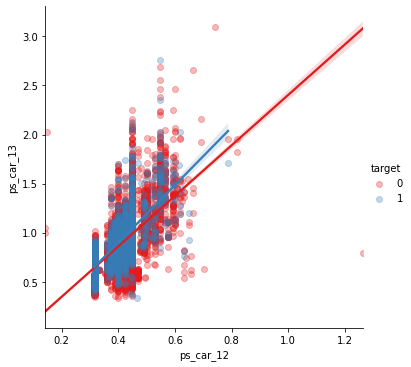

In [44]:
sns.lmplot(x = 'ps_car_12', y = 'ps_car_13', data = s, hue = 'target', palette = 'Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_12와 ps_car_14

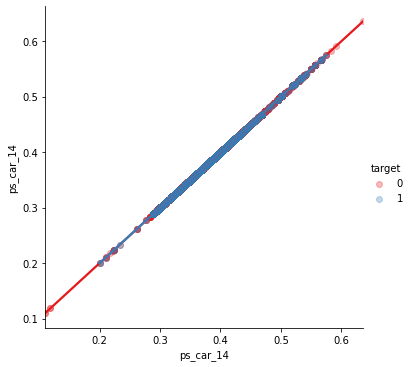

In [45]:
sns.lmplot(x = 'ps_car_14', y = 'ps_car_14', data = s, hue = 'target', palette = 'Set1', scatter_kws={'alpha':0.3})
plt.show()

ps_car_13과 ps_car_15

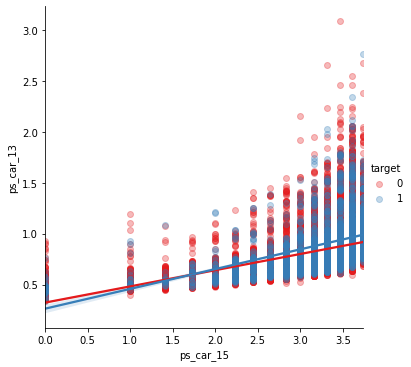

In [46]:
sns.lmplot(x = 'ps_car_15', y = 'ps_car_13', data = s, hue = 'target', palette = 'Set1', scatter_kws={'alpha':0.3})
plt.show()

어떤 상관관계가 있는 변수를 남겨둘지 어떻게 결정할까? 우리는 차원을 줄이기 위해 변수에 대해 주성분분석(PCA)를 실시할 수 있다. 

하지만 상관관계를 갖는 변수의 수가 적어서 모델이 헤비 리프팅을 하도록 둘 것이다

#그냥 둔다는 뜻인듯

**서수 변수 사이의 상관관계 확인**

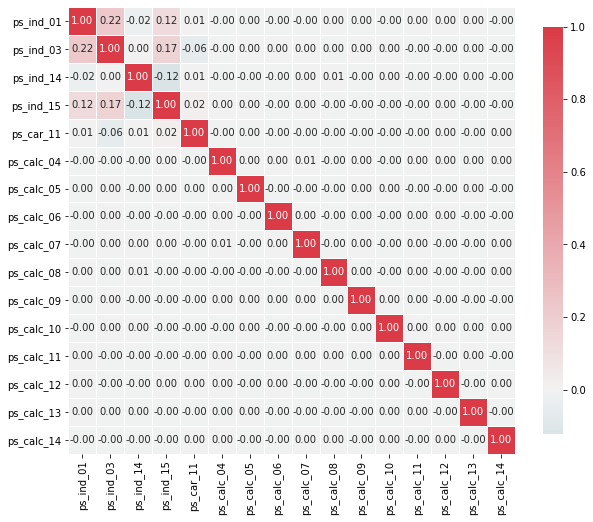

In [47]:
v = meta[(meta.level == 'ordival') & (meta.keep)].index
corr_heatmap(v)

여기에는 많은 상관관계가 보이지 않는다. 타겟 값으로 그룹을 지었을 때 분포를 볼 수 있을 것이다

**특성 다루기**

**더미변수 만들기**

카테고리 변수의 값은 어떤 순서나 크기를 대표하지 않는다. 예를 들어, 카테고리2는 카테고리1의 두 배가 아니다. 그러므로 우리는 이를 다루기 위해 더미 변수를 만들 수 있다. 첫 번째 더미 변수는 원래 변수의 범주에 대해 생성된 다른 더미 변수에서 파생될 수 있으므로 삭제한다.

In [48]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


그래서 더미변수를 만들어서 트레인 셋에 52개의 변수를 추가했다

#더미변수 뭐더라
1. 중졸이하 2. 고졸 3. 대졸 4. 대학원 이상
이렇게 있으면 1,2,3,4 이 숫자는 의미 없다. 2배 이런 것도 아니고 그냥 명목상 있는 숫자니까. 그래서 1, 0, 0, 0 이런식으로 만드는 것. 그래서 변수 수가 늘어났구나

**상호작용하는 변수 만들기**

In [49]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # 원래 열 삭제
# 트레인 데이터에 상호작용 변수 합치기
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train


이것은 트레인 데이터에 상호작용하는 변수를 더했다. 
get_feature_names 방법으로 이 새 변수들에 열 이름을 부여할 수 있다

#이건 뭐고 왜 하는거지

**특성 선택**

**분산이 낮거나 0인 특성 제거**

개인적으로 분류 알고리즘이 어떤 특성을 유지할지 고르게 하는 것을 선호한다. 하지만 우리 스스로 할 수 있는 하나가 있다. 바로 분산이 낮거나 없는 특성을 제거하는 것이다. #의미x?

sklearn은 VarianceThreshold 메서드를 가지고 있다. 기본적으로 분산이 0인 특성을 제거한다. 이것은 이 데이터에는 적용할 수 없을 것이다. 왜냐면 분산이 0인 변수가 없기 때문이다. 하지만 1% 이하의 분산을 가지는 특성을 제거한다면 우리는 31개의 변수를 제거할 수 있다.

In [50]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # id와 타겟 특성 제외

f = np.vectorize(lambda x : not x) # 불린 배열 요소를 전환하는 함수

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


분산을 기준으로 선택한다면 많은 변수를 잃을 수 있다. 하지만 우리는 변수가 많지 않기 때문에 분류기가 고를 수 있도록 둘 것이다. 더 많은 분산을 가진 데이터 셋으로는 처리 시간을 줄일 수 있다. 

**랜덤포트와 SelectFromModel으로 특성 선택하기**

원래는 특성 중요성의 레벨을 세팅할 수 있지만 간단하게 50%의 가장 좋은 변수를 고르도록 하겠다.

In [51]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.021205
 2) ps_car_13                      0.017377
 3) ps_car_13^2                    0.017224
 4) ps_car_12 ps_car_13            0.017211
 5) ps_car_13 ps_car_14            0.017160
 6) ps_reg_03 ps_car_13            0.017062
 7) ps_car_13 ps_car_15            0.016860
 8) ps_reg_01 ps_car_13            0.016713
 9) ps_reg_03 ps_car_14            0.016221
10) ps_reg_03 ps_car_12            0.015634
11) ps_reg_03 ps_car_15            0.015169
12) ps_car_14 ps_car_15            0.015044
13) ps_reg_02 ps_car_13            0.014742
14) ps_car_13 ps_calc_01           0.014736
15) ps_car_13 ps_calc_03           0.014695
16) ps_reg_01 ps_reg_03            0.014680
17) ps_car_13 ps_calc_02           0.014674
18) ps_reg_01 ps_car_14            0.014403
19) ps_reg_03                      0.014283
20) ps_reg_03^2                    0.014259
21) ps_reg_03 ps_calc_03           0.013779
22) ps_reg_03 ps_calc_01           0.013760
23) ps_reg_03 ps_calc_02        

In [52]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 162
Number of features after selection: 81


In [53]:
train = train[selected_vars + ['target']]

**특성 스케일링**

전에도 언급했듯, 트레인 데이터에 대해 standard scaling을 적용할 수 있다. 몇몇 분류기는 스케일링을 하면 성능이 더 좋아진다.

In [54]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])